# Analyse results of hyperopt search

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import patsy
import pickle
import numpy as np
import scanpy as sc

from matplotlib import rcParams

import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri

import sys  
sys.path.insert(0, '/lustre/groups/ml01/workspace/karin.hrovatin/code/diabetes_analysis/')
import helper as h

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [29]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/ref_combined/scVI/hyperopt/'
UID2='eval_scVI_ref'

In [30]:
folder_name='1599165129.871496_2000_mll/'

## Run parameters analysis

In [35]:
# Read parameters
params_res=pd.read_table(path_data+folder_name+'trials_ref.tsv',sep='\t')

Top 10 runs

In [36]:
# Display top 10 runs - based on marginal_ll
params_res.sort_values('marginal_ll').iloc[:10,:]

,marginal_ll,n_layers,n_hidden,n_latent,reconstruction_loss,dropout_rate,lr,dispersion,n_epochs,n_params,run index
0,897.472559,2,256,20,zinb,0.1,0.001,gene-batch,108,1165312,95
1,897.486295,2,256,20,zinb,0.1,0.001,gene-batch,107,1165312,84
2,897.605908,3,256,20,zinb,0.1,0.001,gene-batch,104,1296384,69
3,897.789326,3,256,20,zinb,0.1,0.001,gene-batch,103,1296384,75
4,897.815417,3,256,20,zinb,0.1,0.001,gene-batch,107,1296384,77
5,897.865117,3,256,20,zinb,0.1,0.001,gene-batch,102,1296384,70
6,897.927527,3,256,20,zinb,0.1,0.001,gene-batch,104,1296384,74
7,897.996029,3,256,12,zinb,0.1,0.001,gene-batch,107,1292288,65
8,898.094973,3,256,20,zinb,0.1,0.001,gene-batch,91,1296384,80
9,898.122303,3,256,20,zinb,0.1,0.001,gene-batch,98,1296384,68


Distribution of metric based on parameter values (not adjusted for other parameters).

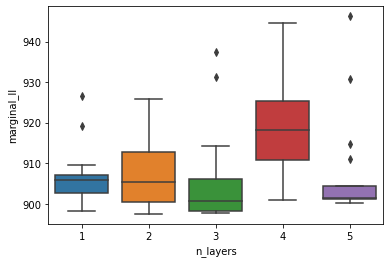

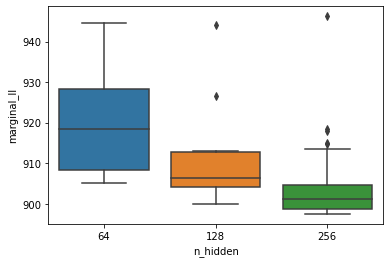

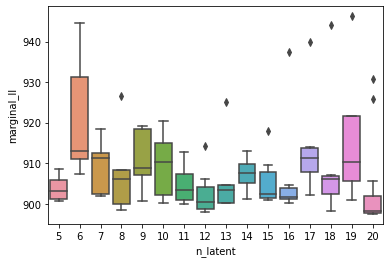

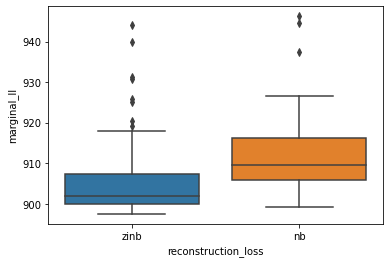

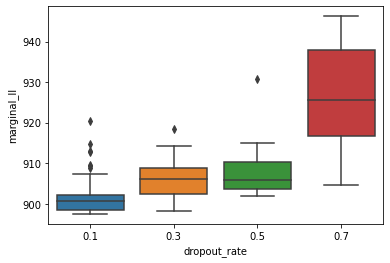

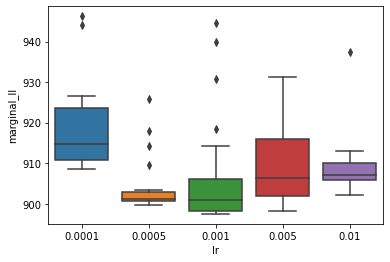

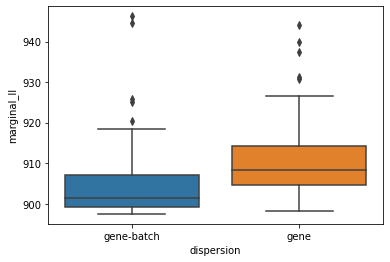

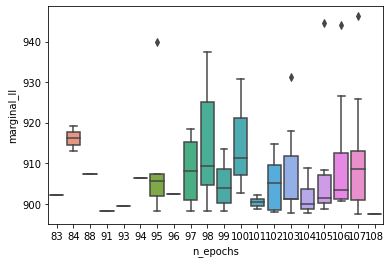

In [37]:
# Boxplot metric vs param for each param
metric='marginal_ll'
for param in params_res.columns:
    # Remove non-parameters
    if param not in ['marginal_ll','n_params','run index']:
        plt.subplots()
        sb.boxplot(x=param,y=metric,data=params_res)

Note on hyperopt model selection: This relies on mll, which is most likely not of the same quality for evaluation of integration as scIB evaluation used elsewhere. However, for some of the below parameters that we decided to change from the default we also latter used scIB on other datasets and got consistently similar results (e.g. higher n_hidden).

Aproximately determine most important parameters with multiple regression (not very reliable due to possibly non-linear relationship). 

In [38]:
# Prepare data for linear regression
# Use intercept to get proper encoding of categorical (single column) but remove it by subsetting array
xs=["n_layers","n_hidden","n_latent","reconstruction_loss","dropout_rate","lr",'dispersion',"n_epochs"]
x_formula=' + '.join(xs)
y_formula = 'marginal_ll'
params_res_matrix=patsy.dmatrix(x_formula, params_res)
col_names=[col.replace('[','').replace(']','').replace('T.','_').replace('-','_') 
           for col in params_res_matrix.design_info.column_names[1:]]
x_formula=' + '.join(col_names)
params_res_matrix=pd.DataFrame(params_res_matrix[:,1:],columns=col_names)
# Add y
params_res_matrix[y_formula]=params_res[y_formula]


Call:
lm(formula = as.formula(paste0(y_formula, " ~ ", x_formula)), 
    data = params_res_matrix)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.7435 -2.9459 -0.0454  1.8961 19.8526 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               9.027e+02  1.263e+01  71.493  < 2e-16 ***
reconstruction_loss_zinb -2.655e+00  1.332e+00  -1.994   0.0492 *  
dispersion_gene_batch    -5.522e-01  1.377e+00  -0.401   0.6894    
n_layers                  3.151e+00  4.571e-01   6.894 6.95e-10 ***
n_hidden                 -6.449e-02  7.379e-03  -8.740 1.10e-13 ***
n_latent                  3.446e-02  1.139e-01   0.303   0.7628    
dropout_rate              3.253e+01  2.557e+00  12.724  < 2e-16 ***
lr                       -2.644e+02  2.111e+02  -1.252   0.2138    
n_epochs                  1.455e-02  1.165e-01   0.125   0.9009    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.218 on 91 degree

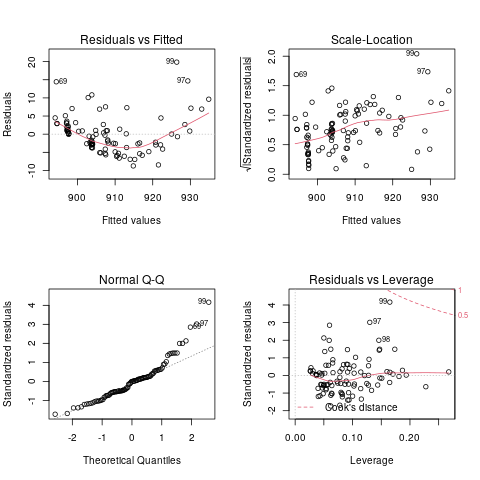

In [39]:
%%R -i params_res_matrix -i x_formula -i y_formula
# Linear regression
fit <- lm(as.formula(paste0(y_formula,' ~ ',x_formula)), data=params_res_matrix)
print(summary(fit))
layout(matrix(c(1,2,3,4),2,2)) # optional 4 graphs/page
plot(fit)

#C: The relationship is not linear - questionable how reliable are the results of the regression.

## Best model

### Training history

In [40]:
trials = pickle.load( open( path_data+folder_name+'trials_ref', "rb" ) )

In [41]:
best_model_idx=params_res.sort_values('marginal_ll').iloc[0,:]['run index']
history=trials.trials[best_model_idx]['result']["history"]["elbo_test_set"]

Plot history. Set ylim top so that very very high losses are not shown.

Text(0, 0.5, 'test loss')

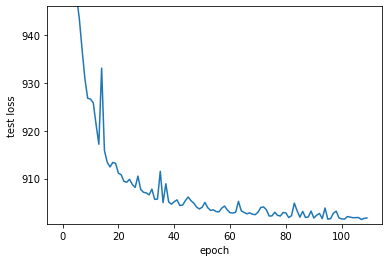

In [42]:
plt.plot(range(len(history)),history)
# Use this to remove outliers
plt.ylim(bottom= min(history)-min(history)*0.001,top=np.quantile(history, 0.95))
plt.xlabel('epoch')
plt.ylabel('test loss')

### Latent sapce

In [43]:
latent=h.open_h5ad(file=path_data+folder_name+'latent.h5ad',unique_id2=UID2)

In [44]:
# Compute random indices for adata cells so that they can be plotted in random order (since they are stored in batch order)
random_indices=np.random.permutation(list(range(latent.shape[0])))

Trying to set attribute `.uns` of view, copying.


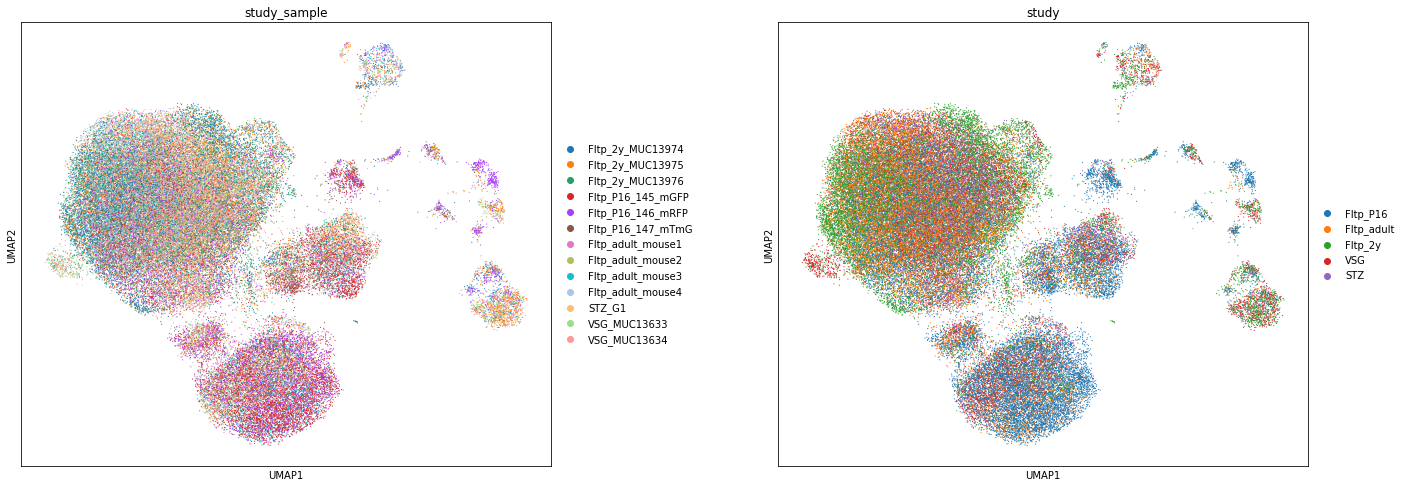

Trying to set attribute `.uns` of view, copying.


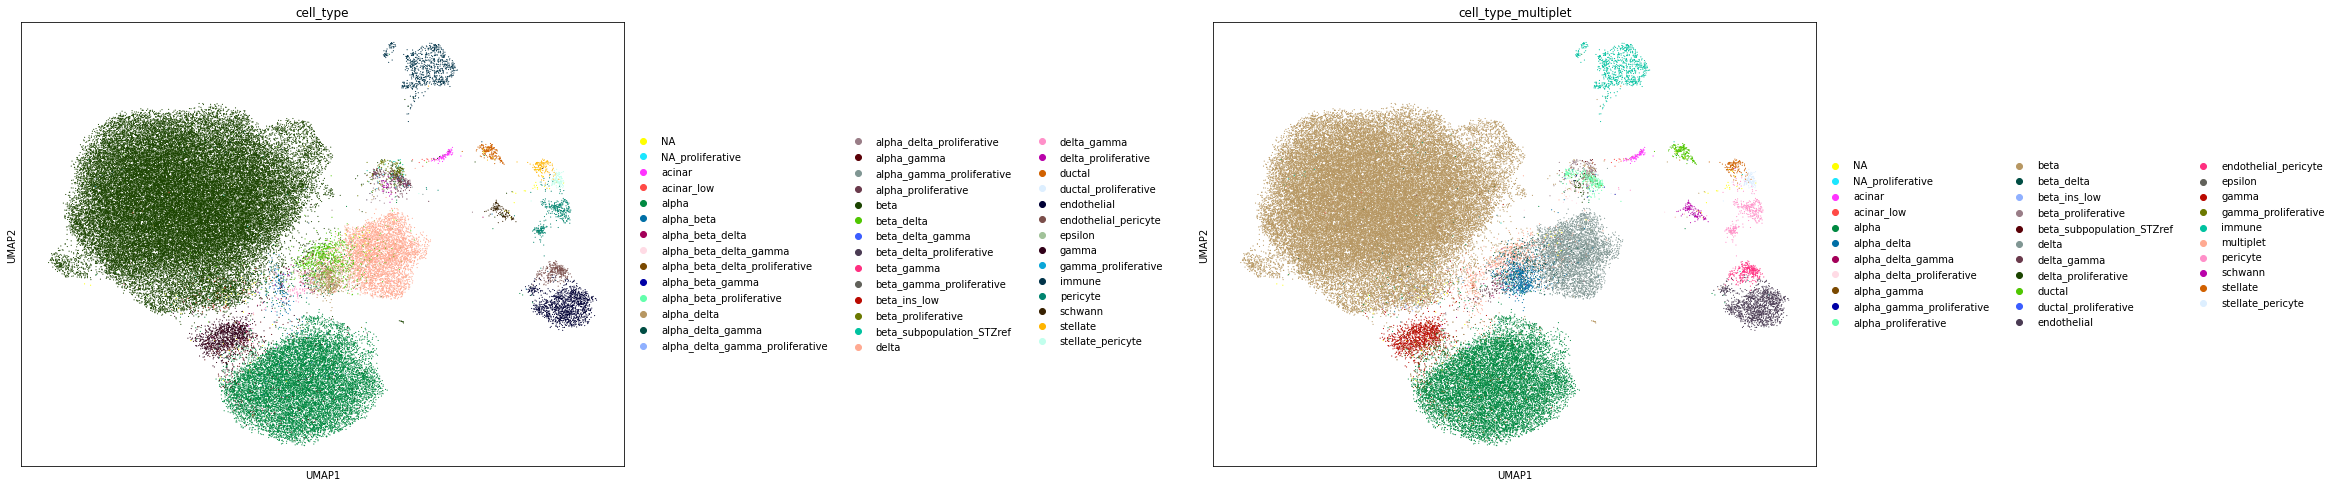

In [45]:
rcParams['figure.figsize']= (9,8)
sc.pl.umap(latent[random_indices,:],color=['study_sample','study'],wspace=0.3,s=5)
sc.pl.umap(latent[random_indices,:],color=['cell_type','cell_type_multiplet'],wspace=0.8,s=5)

### Embedding of only beta cells

Select beta populations

In [46]:
[ct for ct in latent.obs.cell_type_multiplet.unique() if 'beta' in ct]

['beta',
 'beta_proliferative',
 'beta_delta',
 'beta_subpopulation_STZref',
 'beta_ins_low']

In [47]:
selected_beta=['beta',
 'beta_proliferative',
 'beta_subpopulation_STZref',
 'beta_ins_low']

In [48]:
latent_beta=latent[latent.obs.cell_type.isin(selected_beta),:].copy()

In [49]:
sc.pp.neighbors(latent_beta,n_pcs=0)
sc.tl.umap(latent_beta)

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'

In [50]:
random_indices_beta=np.random.permutation(list(range(latent_beta.shape[0])))

Trying to set attribute `.uns` of view, copying.


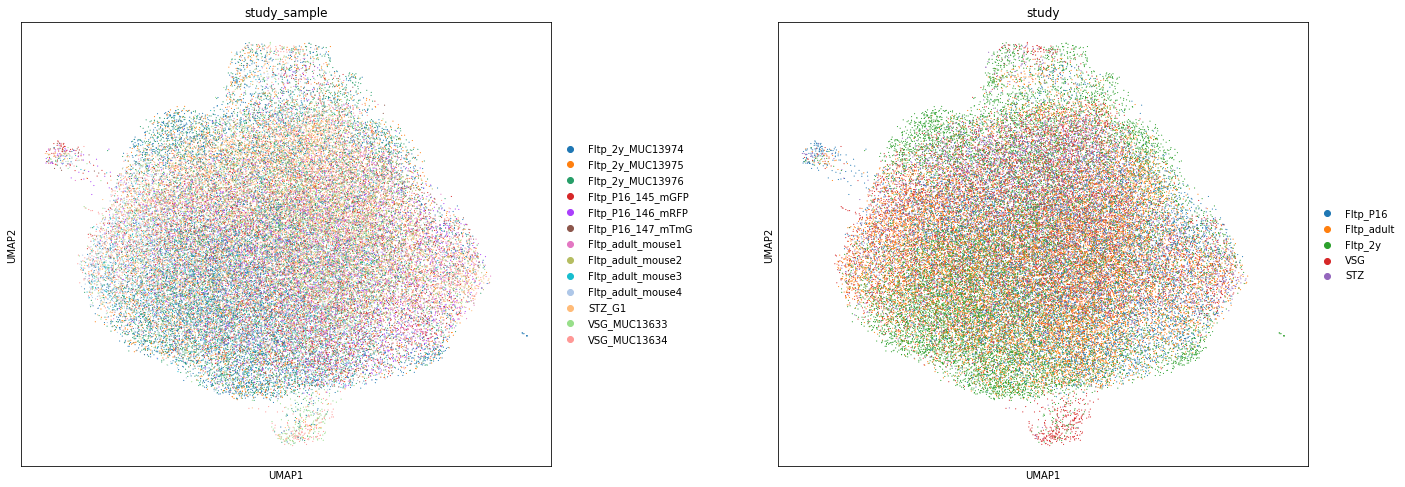

Trying to set attribute `.uns` of view, copying.


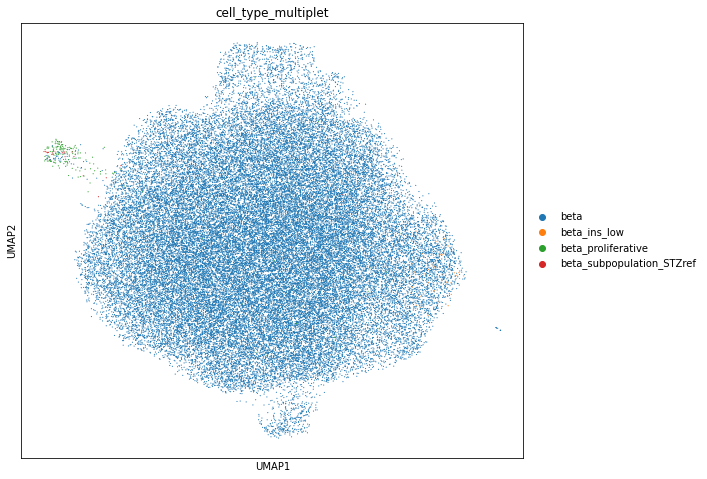

In [51]:
sc.pl.umap(latent_beta[random_indices_beta,:],color=['study_sample','study'],wspace=0.3,s=5)
sc.pl.umap(latent_beta[random_indices_beta,:],color=['cell_type_multiplet'],wspace=0.8,s=5)